In [2]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define the models, datasets, and replacement directions
models = [
    "BioMistral-BioMistral-7B",
    "EleutherAI-gpt-neo-2.7B",
    "EleutherAI-pythia-70m",
    "openai-community-gpt2-xl",
]
datasets = [
    "anatomy",
    "clinical_knowledge",
    "college_biology",
    "college_medicine",
    "medical_genetics",
    "medmcqa",
    "medqa",
    "professional_medicine",
    "pubmed_qa",
    "usmle_sa_step1",
    "usmle_sa_step2",
    "usmle_sa_step3",
]
replacement_directions = ["brand_to_generic", "generic_to_brand", "none"]

# Initialize an empty DataFrame to store the final results
replacements_df = pd.DataFrame()
results_df = pd.DataFrame()

In [4]:
def load_replacement_counts(dataset, direction):
    # Construct the file path for replacement counts
    counts_file_path = (
        f"onBrand/replacement_counts/{dataset}/2024-05-14/{direction}_replacements.json"
    )

    # Load the JSON file if it exists
    if os.path.exists(counts_file_path):
        with open(counts_file_path, "r") as file:
            drug_replacement_counts = json.load(file)

        # Create a DataFrame from the dictionary
        df_replacements = pd.DataFrame(
            list(drug_replacement_counts.items()), columns=["Drug", "Replacements"]
        )
        df_replacements["Dataset"] = dataset
        df_replacements["Direction"] = direction

        return df_replacements
    else:
        return pd.DataFrame(columns=["Drug", "Replacements", "Dataset", "Direction"])


def load_model_results(model, direction):
    # Construct the file path for results
    results_file_path = f"onBrand/results/{model}/{direction}/{direction}_results.json"

    # Load the results JSON file if it exists
    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        # Extract the results for each dataset
        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        # Create a DataFrame for the results
        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Direction"] = direction

        return df_results
    else:
        return pd.DataFrame(
            columns=["Dataset", "Metric", "Value", "Model", "Direction"]
        )

In [5]:
# Iterate through each model, dataset, and direction to load and process the JSON files
for model in models:
    for dataset in datasets:
        for direction in replacement_directions:
            # Load replacement counts
            df_replacements = load_replacement_counts(dataset, direction)

            # Load model results
            df_model_results = load_model_results(model, direction)

            # Append to the respective DataFrames
            if not df_replacements.empty:
                replacements_df = pd.concat(
                    [replacements_df, df_replacements], ignore_index=True
                )
            if not df_model_results.empty:
                results_df = pd.concat(
                    [results_df, df_model_results], ignore_index=True
                )

# Sort the replacements DataFrame by Replacements in descending order
replacements_df = replacements_df.sort_values("Replacements", ascending=False)

# Display the replacements and results DataFrames
print("Replacements DataFrame:")
print(replacements_df.head())

print("\nResults DataFrame:")
print(results_df.head())

Replacements DataFrame:
             Drug  Replacements Dataset         Direction
229726    glucose            64   medqa  generic_to_brand
102764    glucose            64   medqa  generic_to_brand
39283     glucose            64   medqa  generic_to_brand
166245    glucose            64   medqa  generic_to_brand
229894  metformin            50   medqa  generic_to_brand

Results DataFrame:
   Dataset           Metric     Value                     Model  \
0  onBrand              acc  0.409634  BioMistral-BioMistral-7B   
1  onBrand       acc_stderr  0.088686  BioMistral-BioMistral-7B   
2  onBrand         acc_norm  0.414251  BioMistral-BioMistral-7B   
3  onBrand  acc_norm_stderr  0.000304  BioMistral-BioMistral-7B   
4  medmcqa              acc  0.405212  BioMistral-BioMistral-7B   

          Direction  
0  brand_to_generic  
1  brand_to_generic  
2  brand_to_generic  
3  brand_to_generic  
4  brand_to_generic  


In [6]:
results_df.to_csv("results.csv", index=False)
replacements_df.to_csv("replacements.csv", index=False)

## Visualise number replacements


/tmp/ipykernel_468856/1328468393.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_468856/1328468393.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


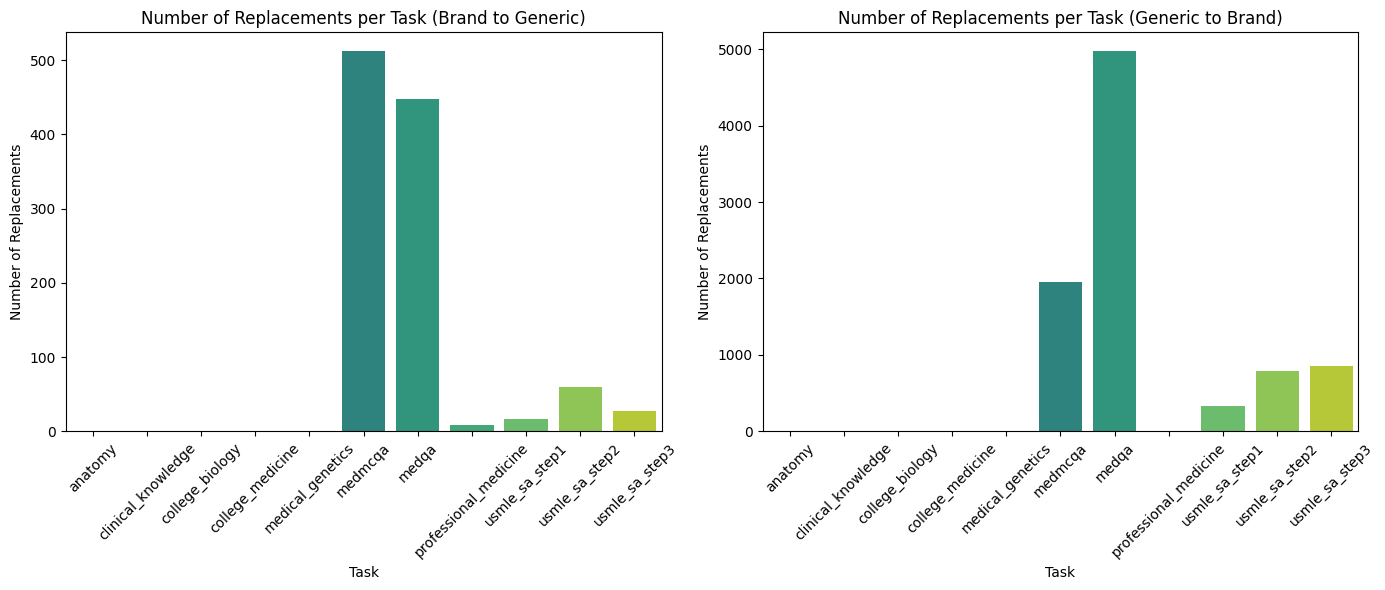

In [7]:
# Filter the replacements DataFrame for "brand_to_generic" and "generic_to_brand"
filtered_replacements_df = replacements_df[
    replacements_df["Direction"].isin(["brand_to_generic", "generic_to_brand"])
]

# Group by Dataset and Direction, and sum the Replacements
grouped_replacements_df = (
    filtered_replacements_df.groupby(["Dataset", "Direction"])["Replacements"]
    .sum()
    .reset_index()
)

# Create separate histograms for each direction
plt.figure(figsize=(14, 6))

# Histogram for brand_to_generic
plt.subplot(1, 2, 1)
sns.barplot(
    data=grouped_replacements_df[
        grouped_replacements_df["Direction"] == "brand_to_generic"
    ],
    x="Dataset",
    y="Replacements",
    palette="viridis",
)
plt.xticks(rotation=45)
plt.title("Number of Replacements per Task (Brand to Generic)")
plt.xlabel("Task")
plt.ylabel("Number of Replacements")

# Histogram for generic_to_brand
plt.subplot(1, 2, 2)
sns.barplot(
    data=grouped_replacements_df[
        grouped_replacements_df["Direction"] == "generic_to_brand"
    ],
    x="Dataset",
    y="Replacements",
    palette="viridis",
)
plt.xticks(rotation=45)
plt.title("Number of Replacements per Task (Generic to Brand)")
plt.xlabel("Task")
plt.ylabel("Number of Replacements")

plt.tight_layout()
plt.show()

## Visualise difference in performance


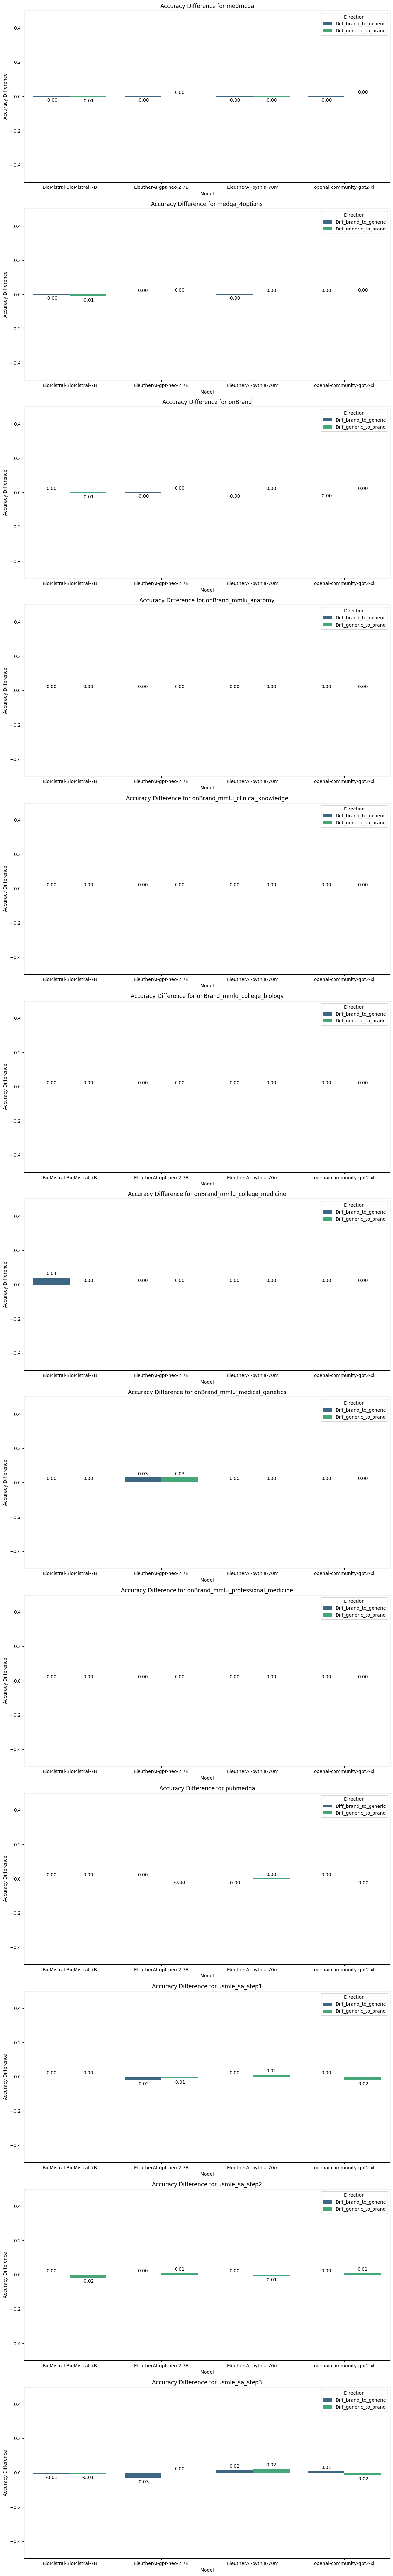

In [37]:
# Filter the results DataFrame to include only accuracy metrics
results_df_filtered = results_df[results_df["Metric"] == "acc"]

# Pivot the DataFrame to have directions as columns
pivot_results = results_df_filtered.pivot_table(
    index=["Dataset", "Model"], columns="Direction", values="Value"
).reset_index()

# Calculate the differences
pivot_results["Diff_brand_to_generic"] = (
    pivot_results["brand_to_generic"] - pivot_results["none"]
)
pivot_results["Diff_generic_to_brand"] = (
    pivot_results["generic_to_brand"] - pivot_results["none"]
)

# Melt the DataFrame for plotting
melted_results = pivot_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_brand_to_generic", "Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

# Create bar plots for each task
tasks = melted_results["Dataset"].unique()
num_tasks = len(tasks)
fig, axes = plt.subplots(nrows=num_tasks, ncols=1, figsize=(12, num_tasks * 6))

for i, task in enumerate(tasks):
    ax = axes[i] if num_tasks > 1 else axes
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        hue="Direction",
        data=melted_results[melted_results["Dataset"] == task],
        palette="viridis",
        ax=ax,
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.legend(title="Direction")
    ax.set_ylim(-0.5, 0.5)  # Adjust the y-axis limits as needed

plt.tight_layout()
plt.show()

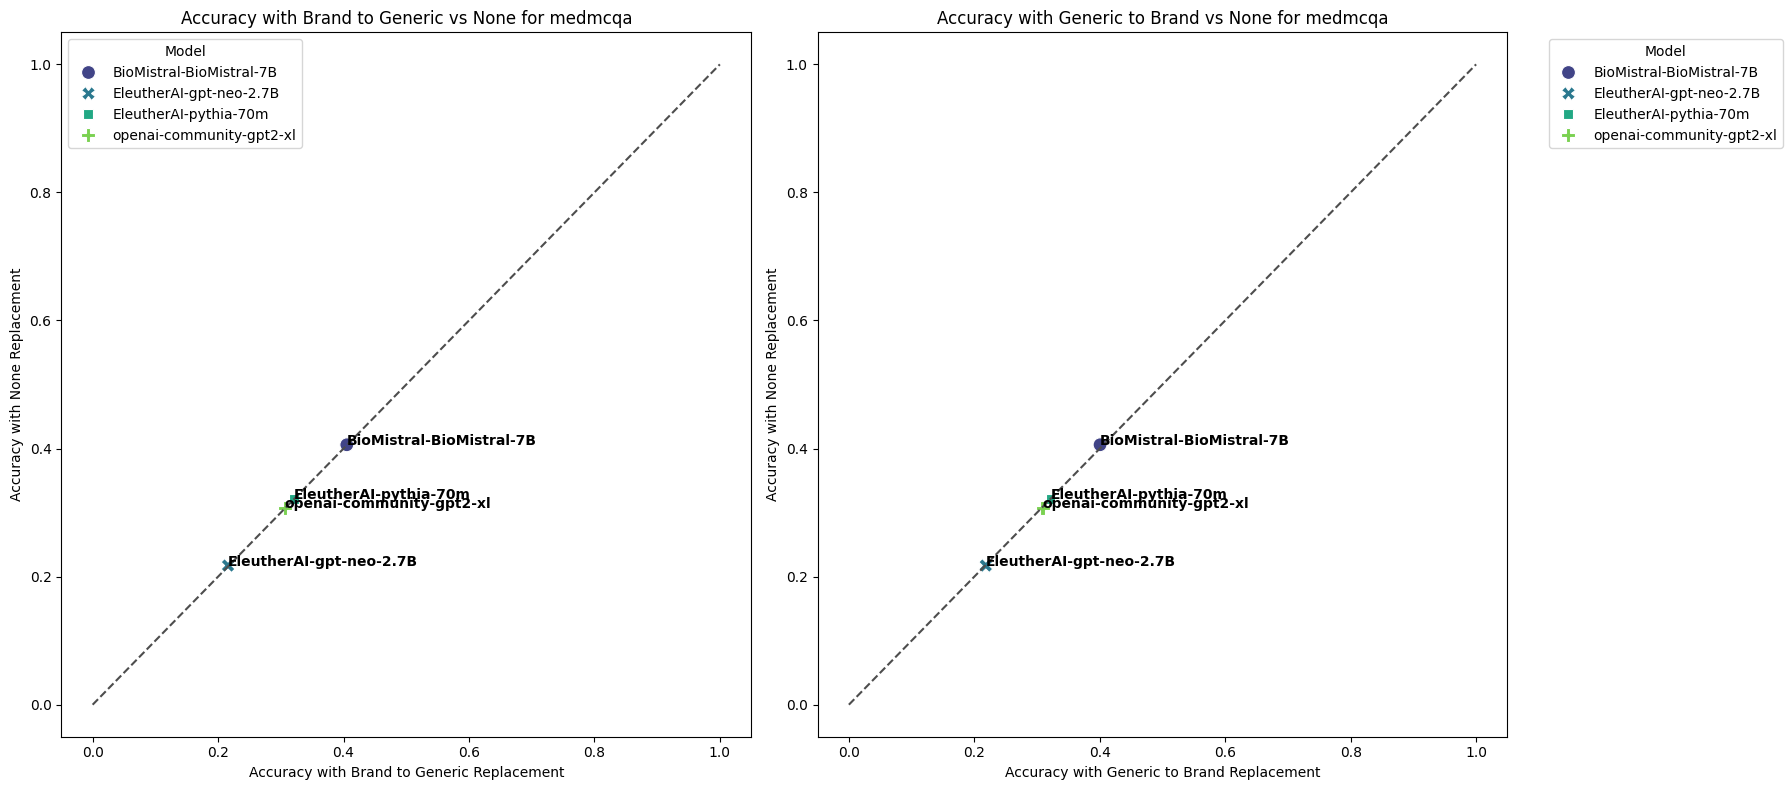

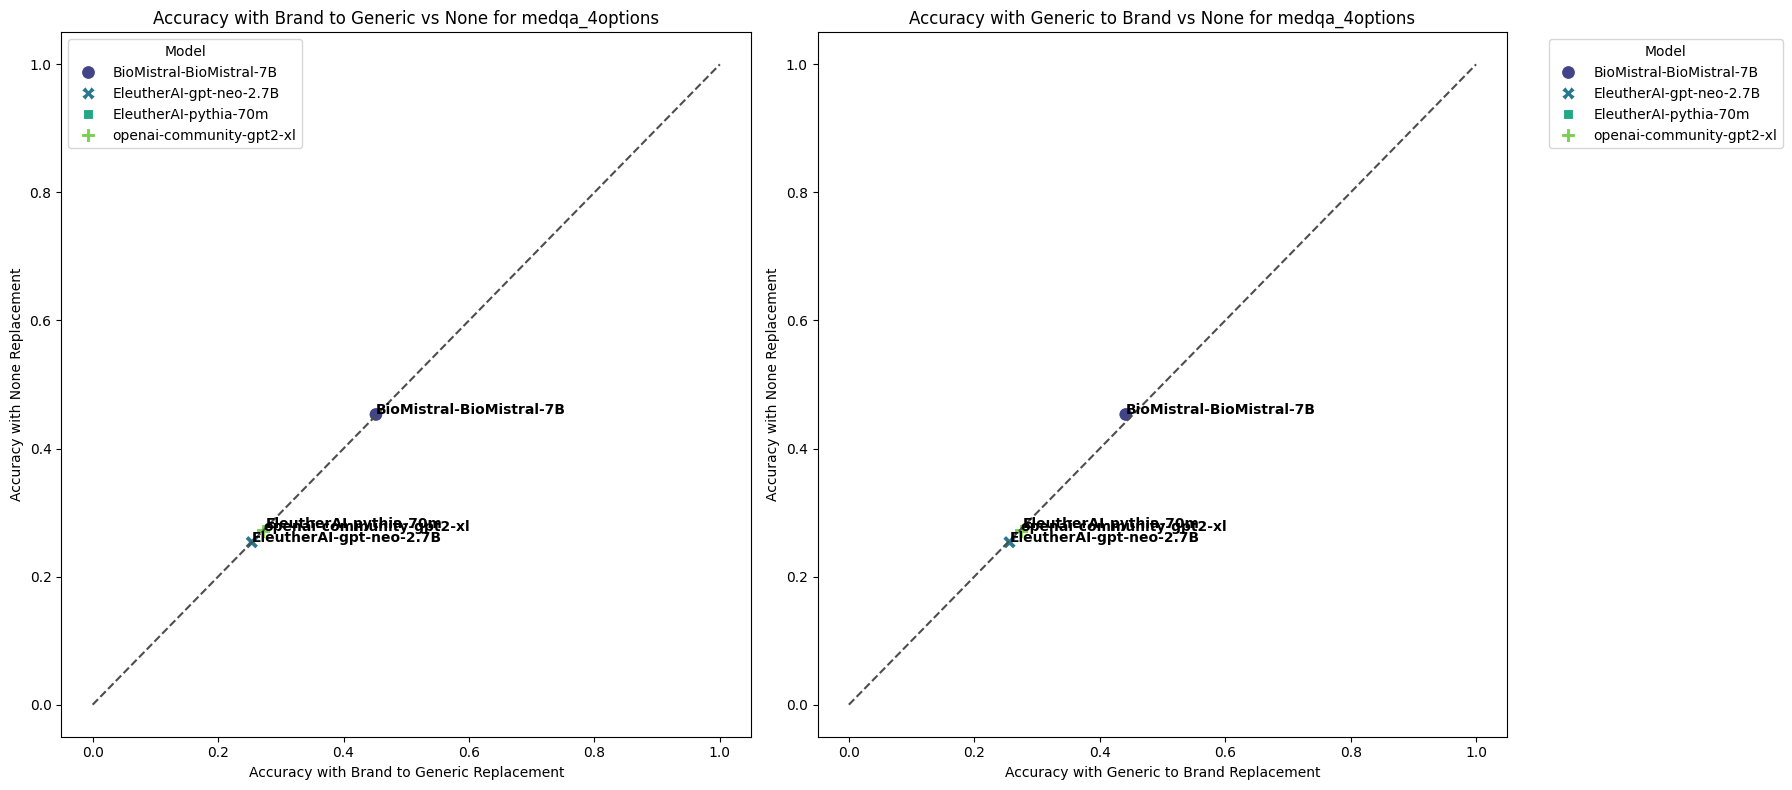

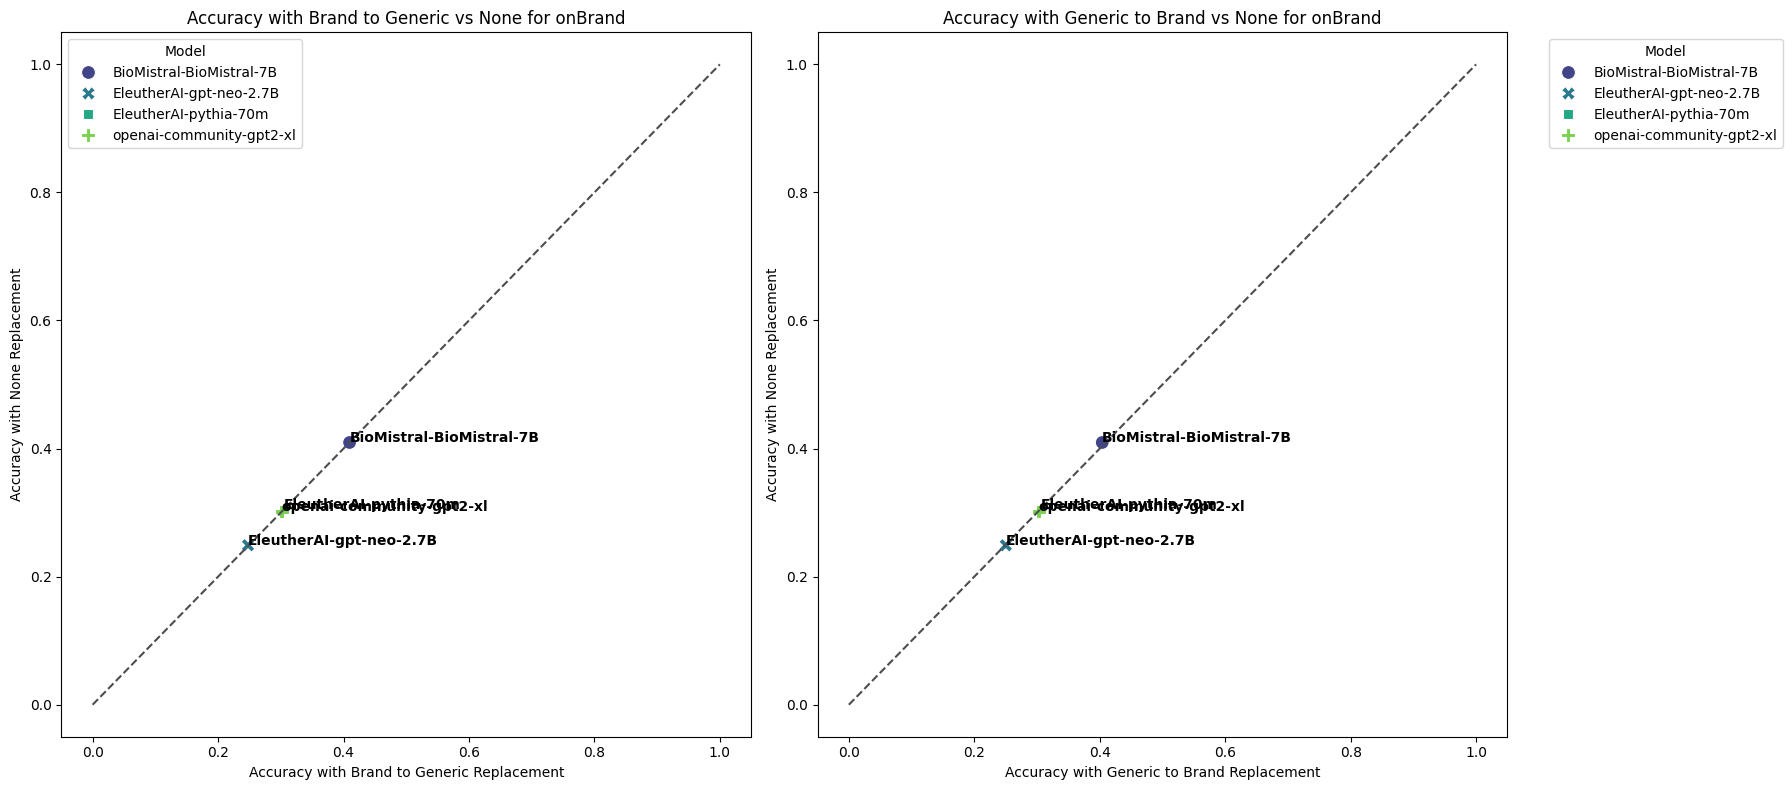

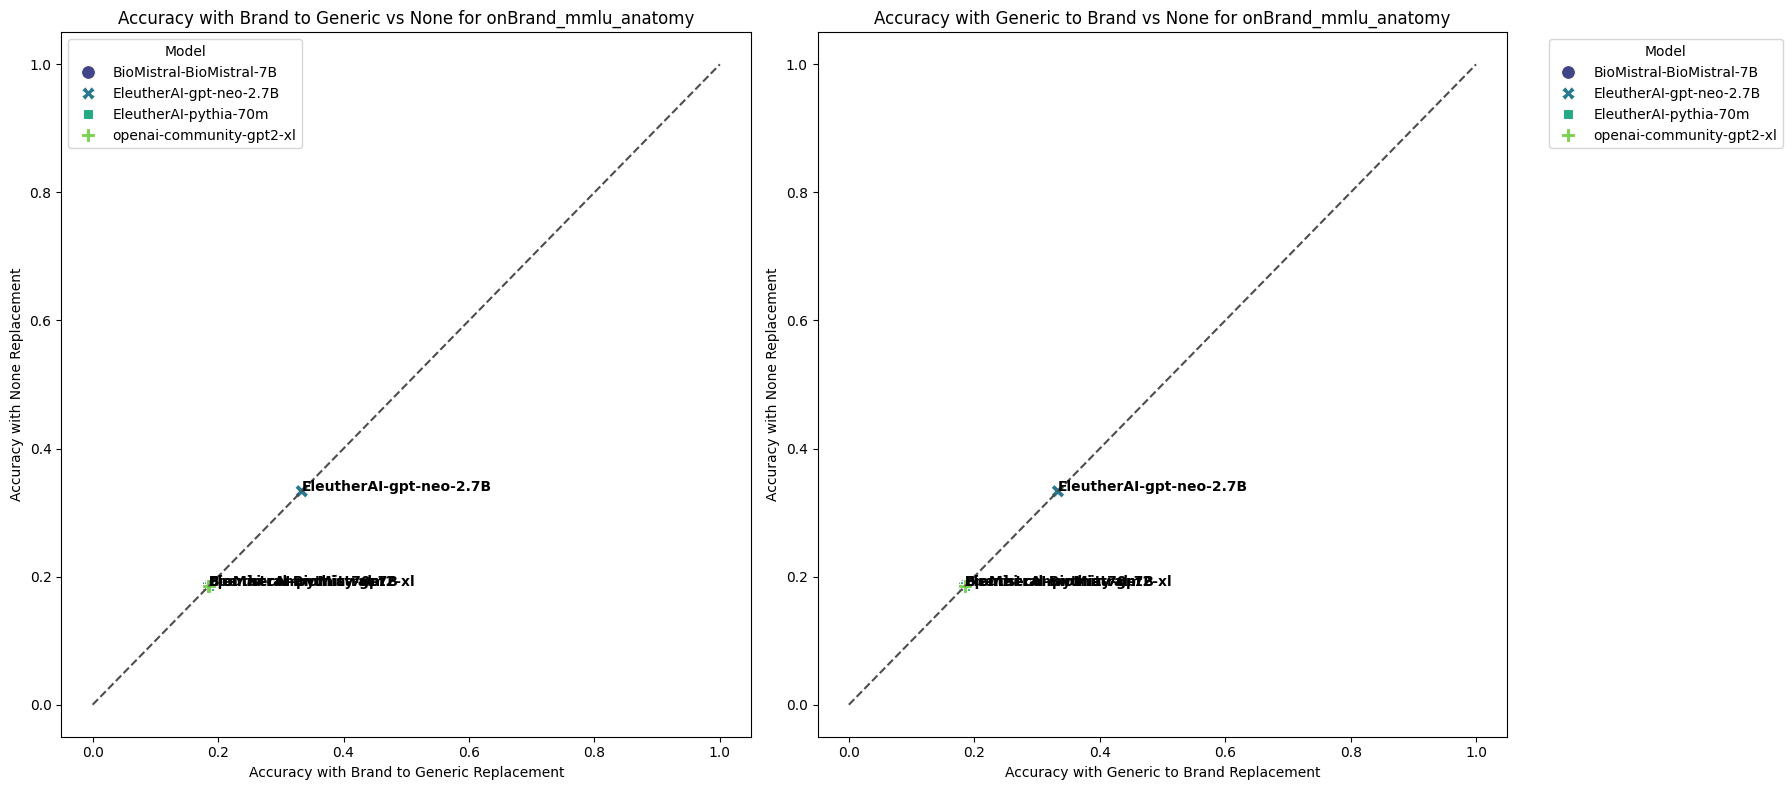

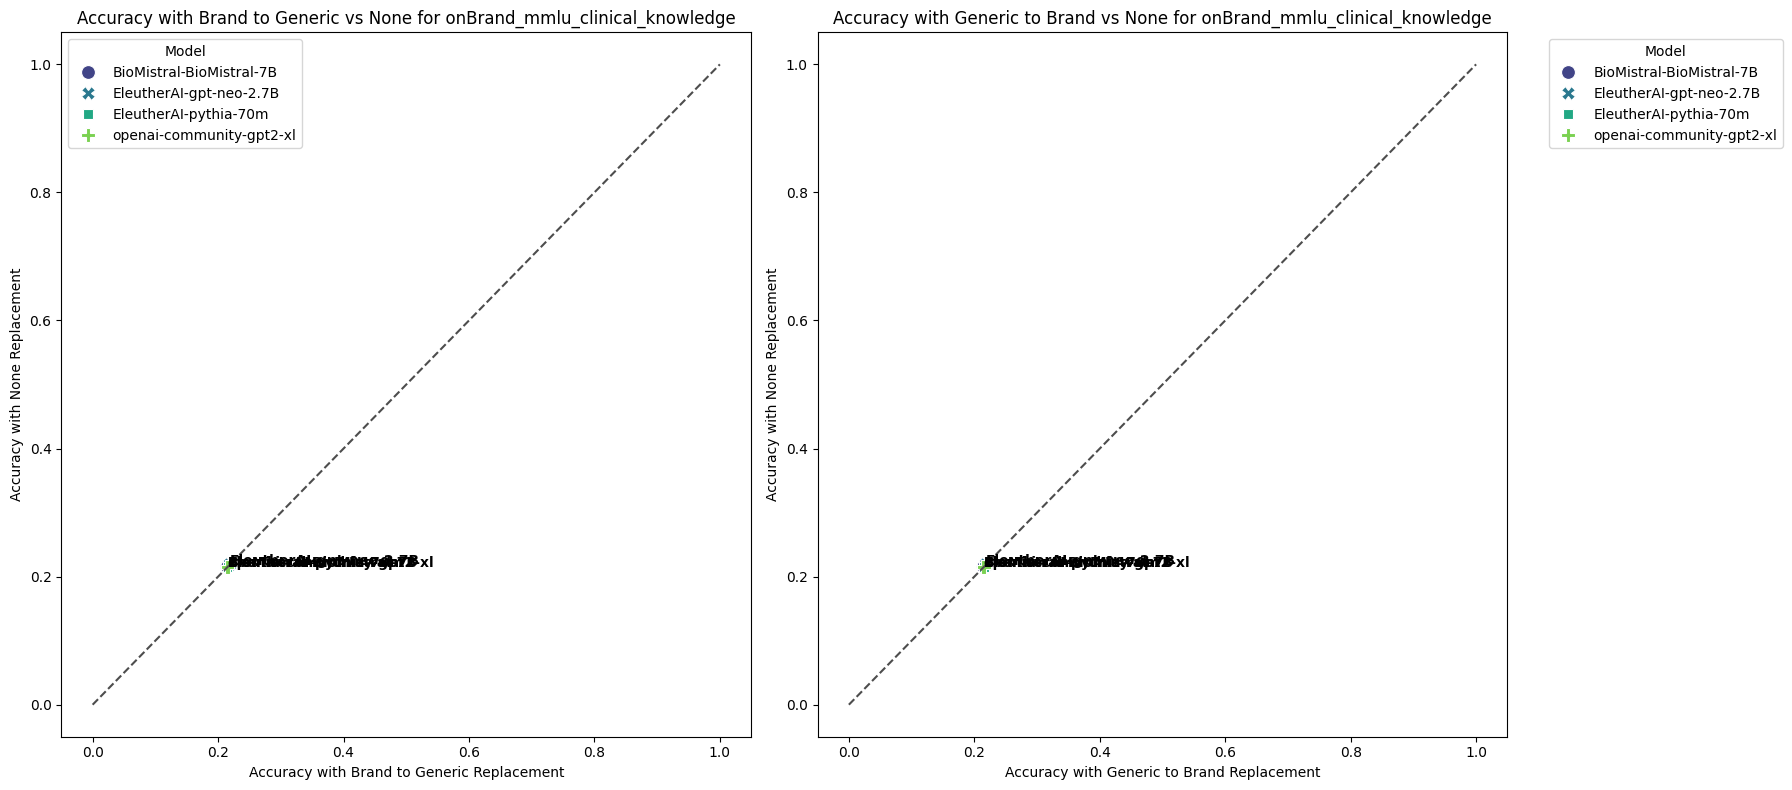

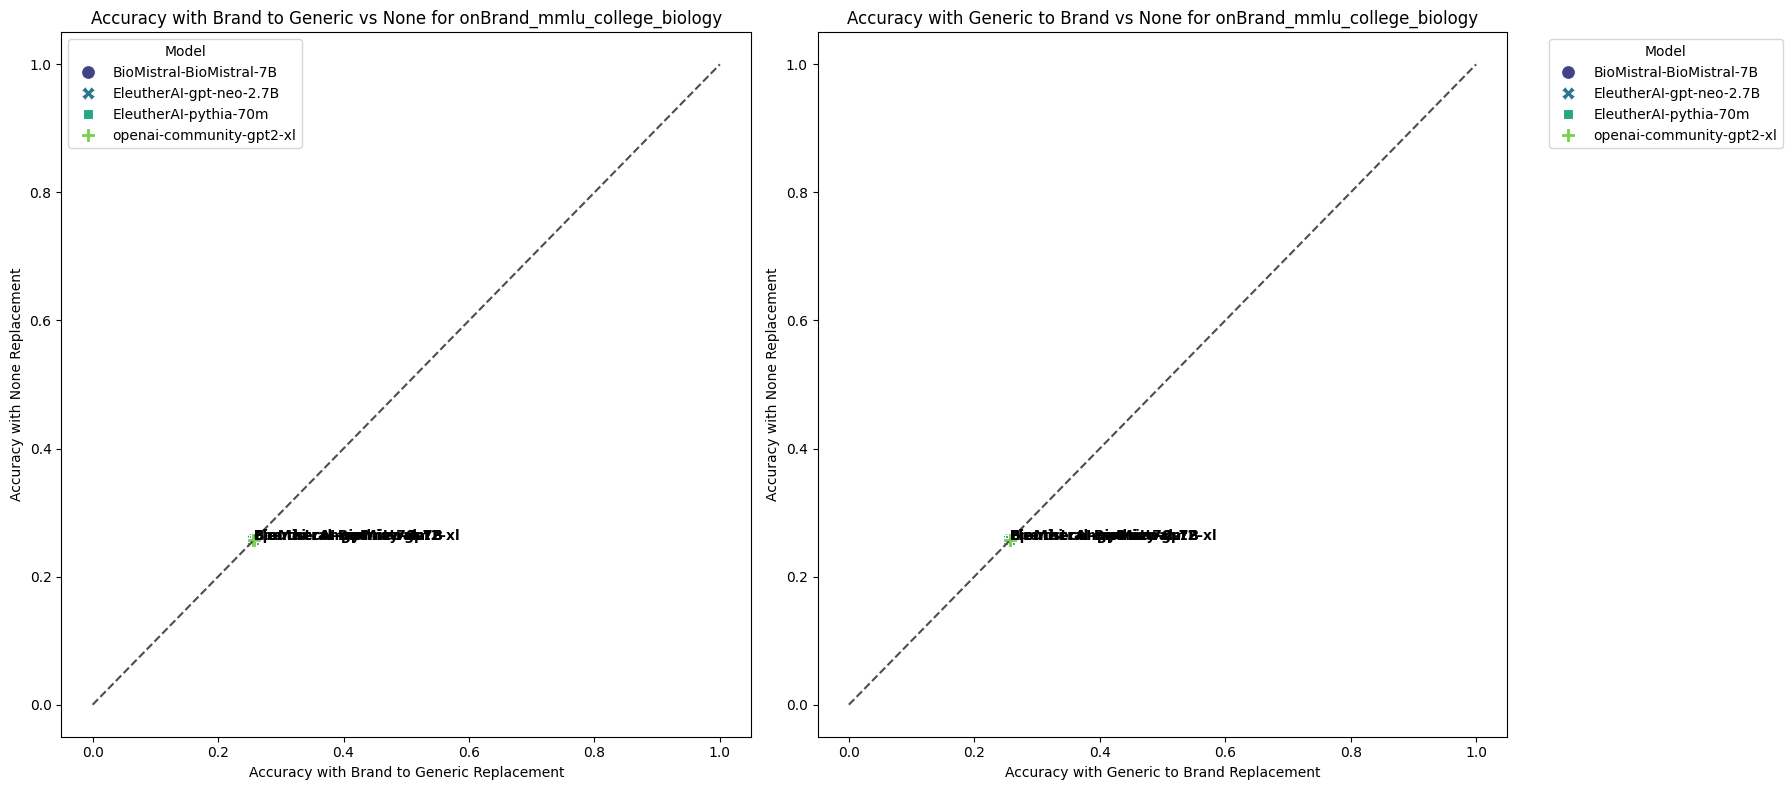

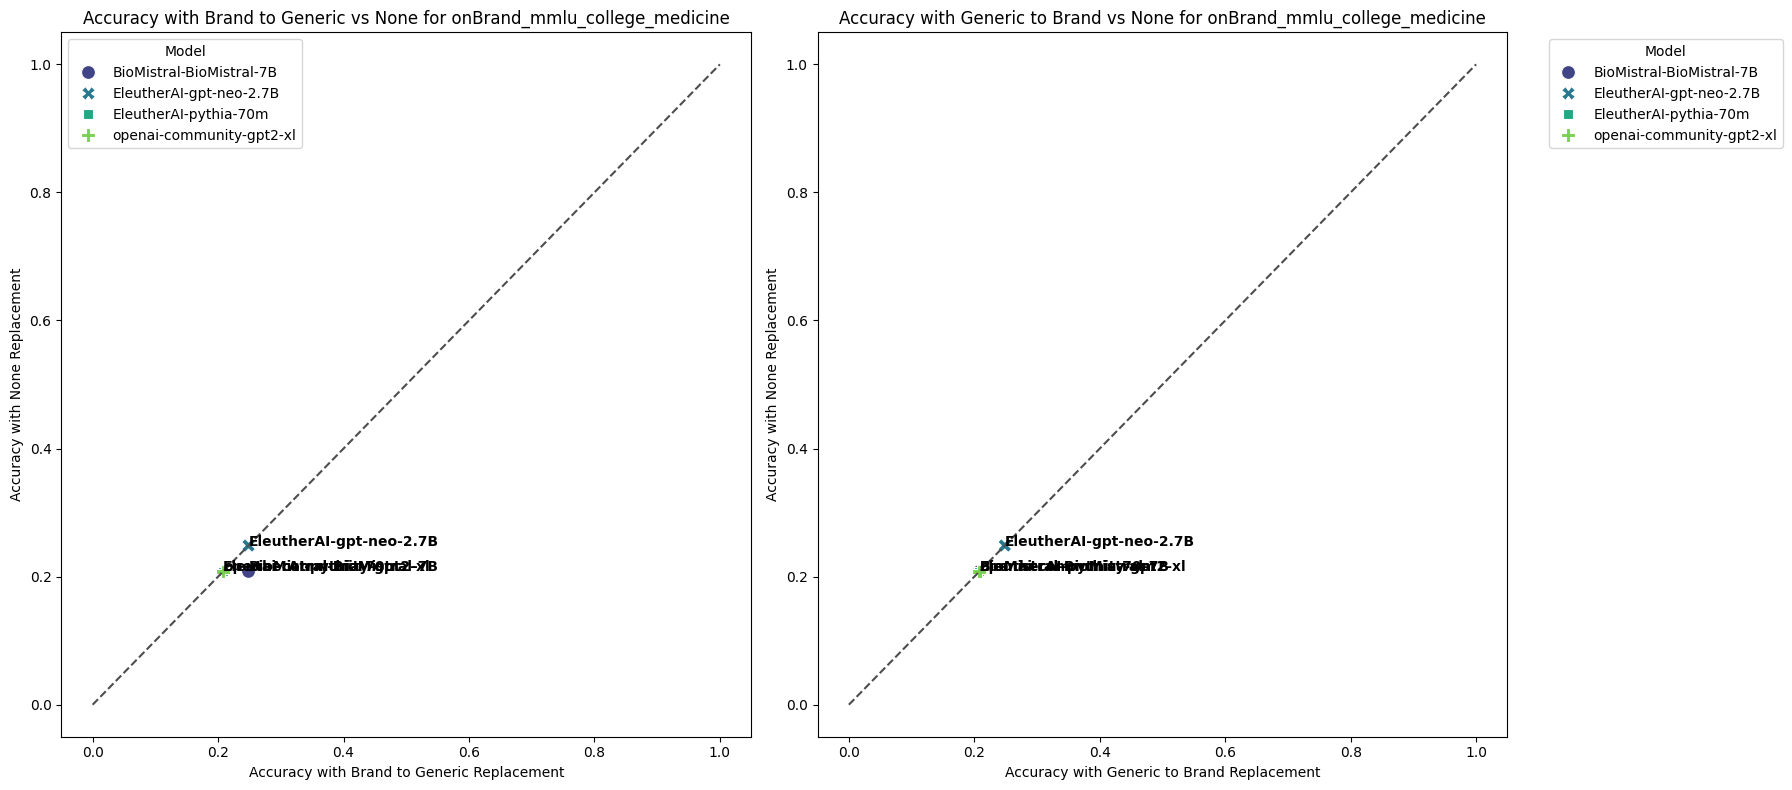

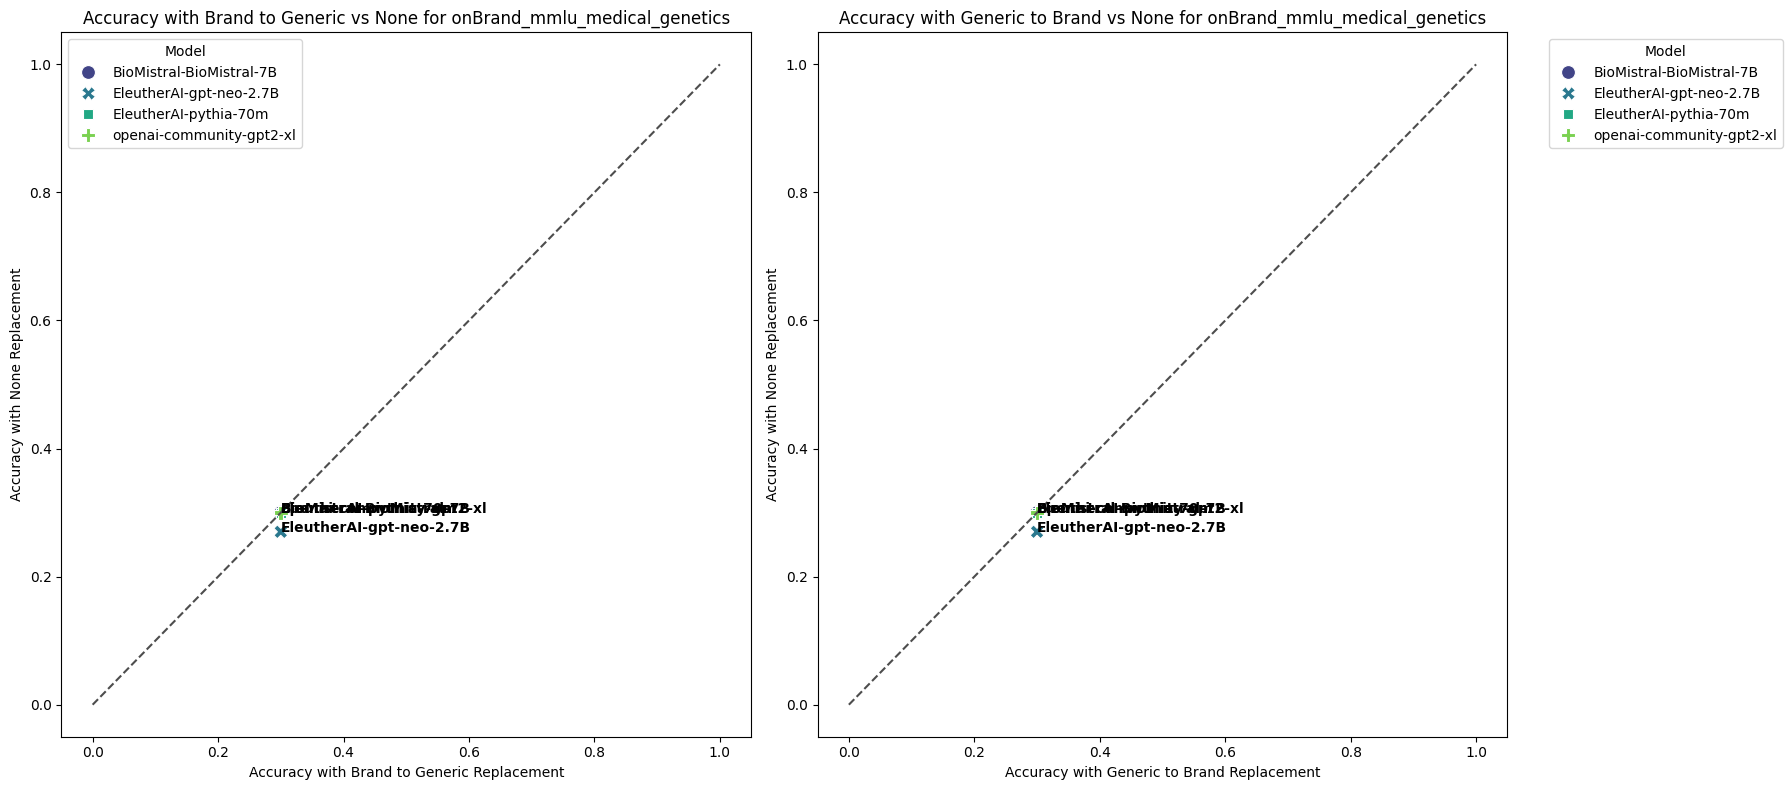

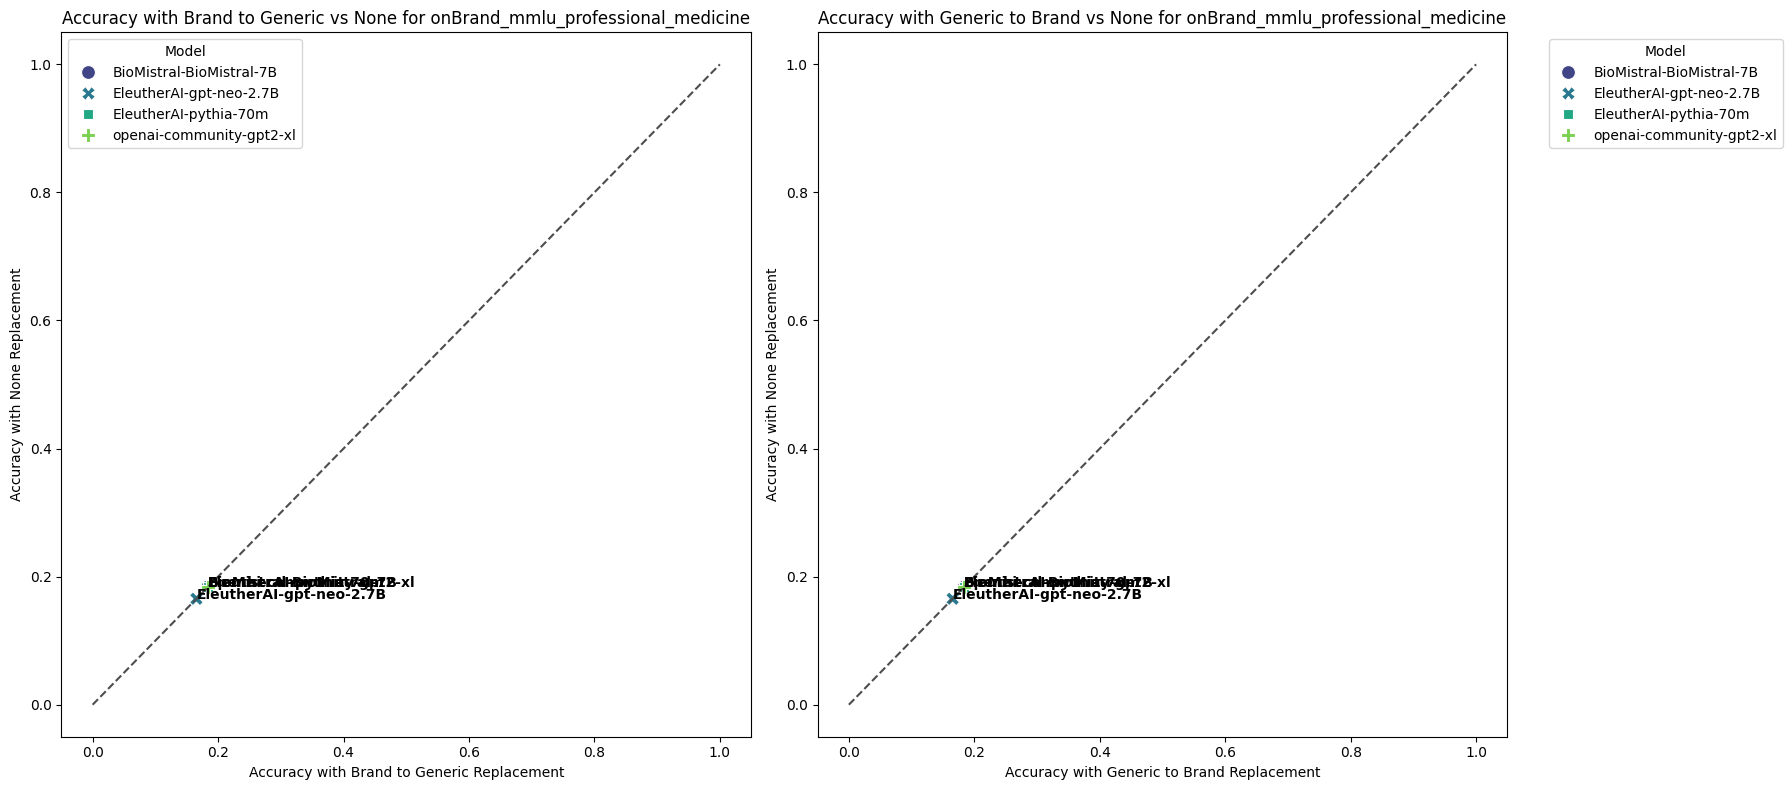

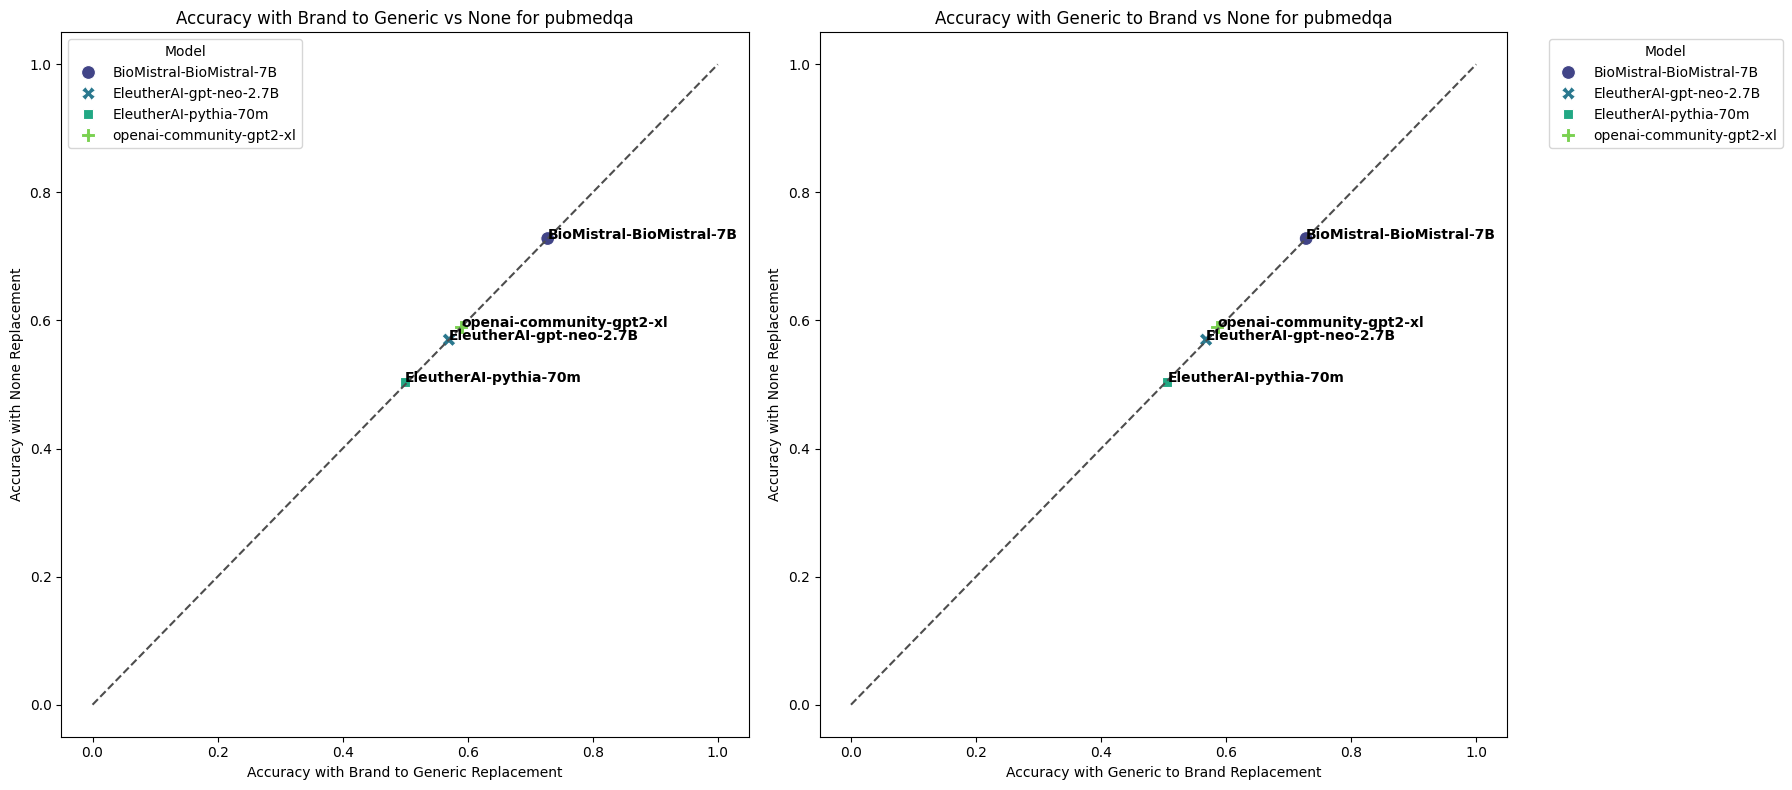

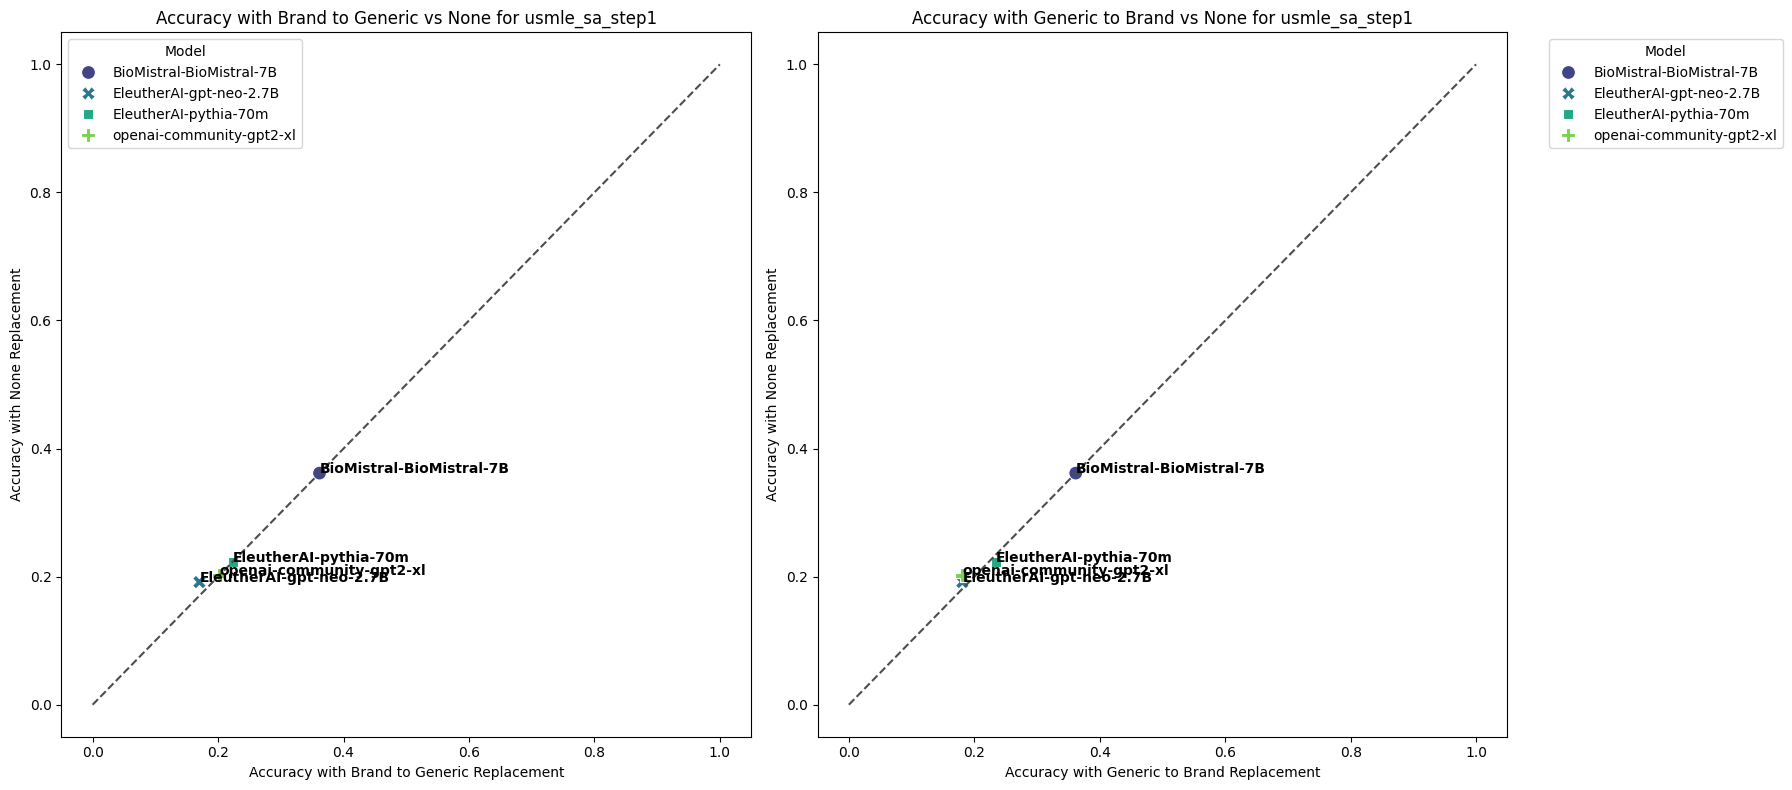

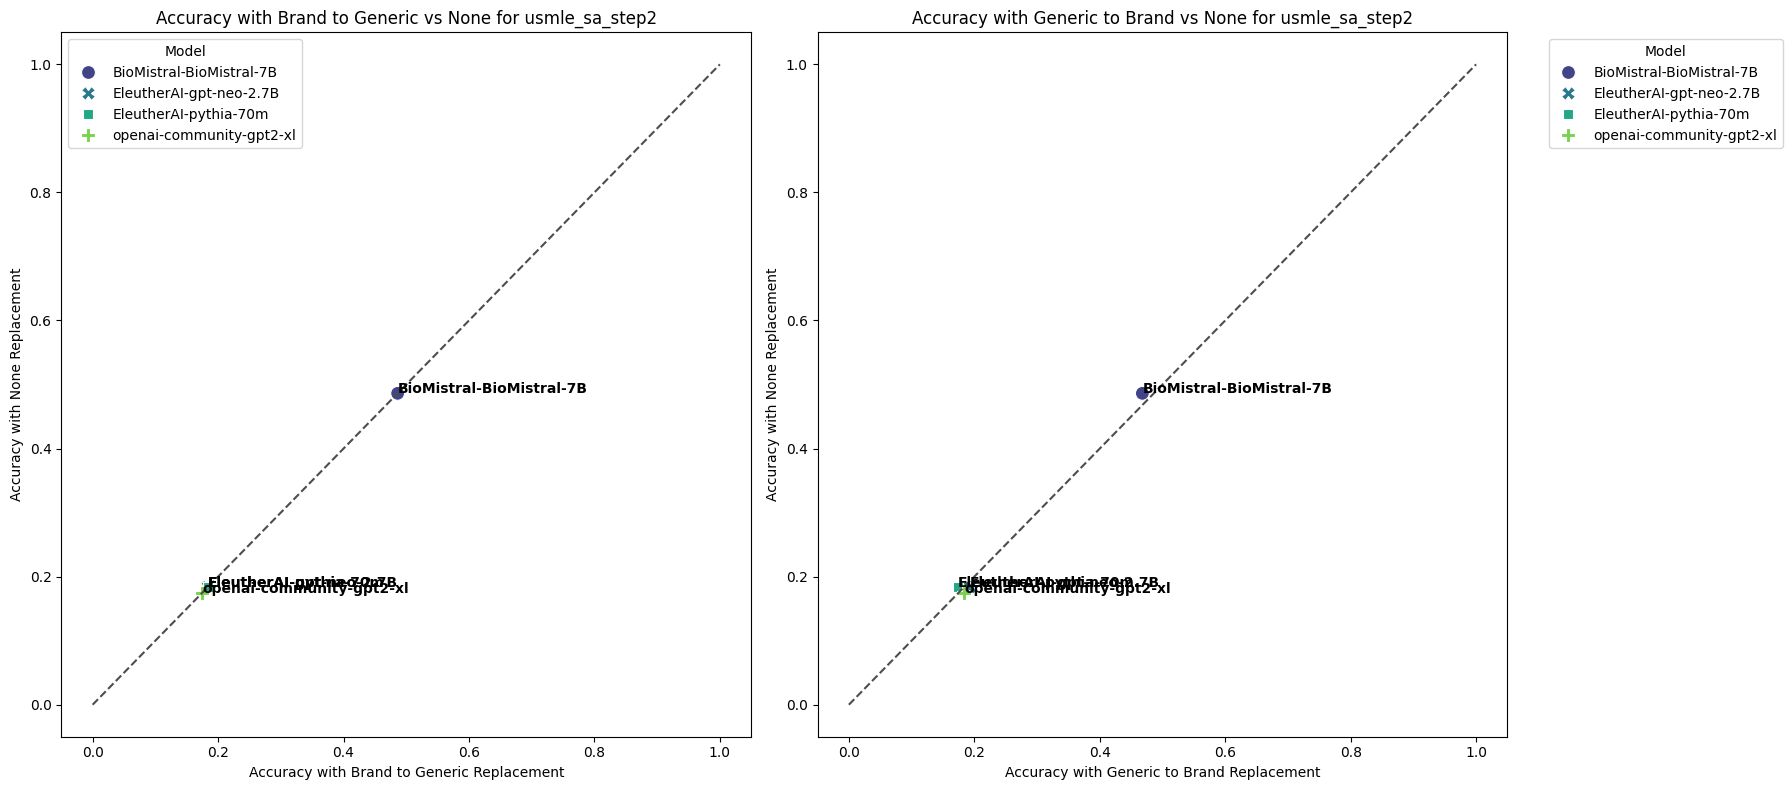

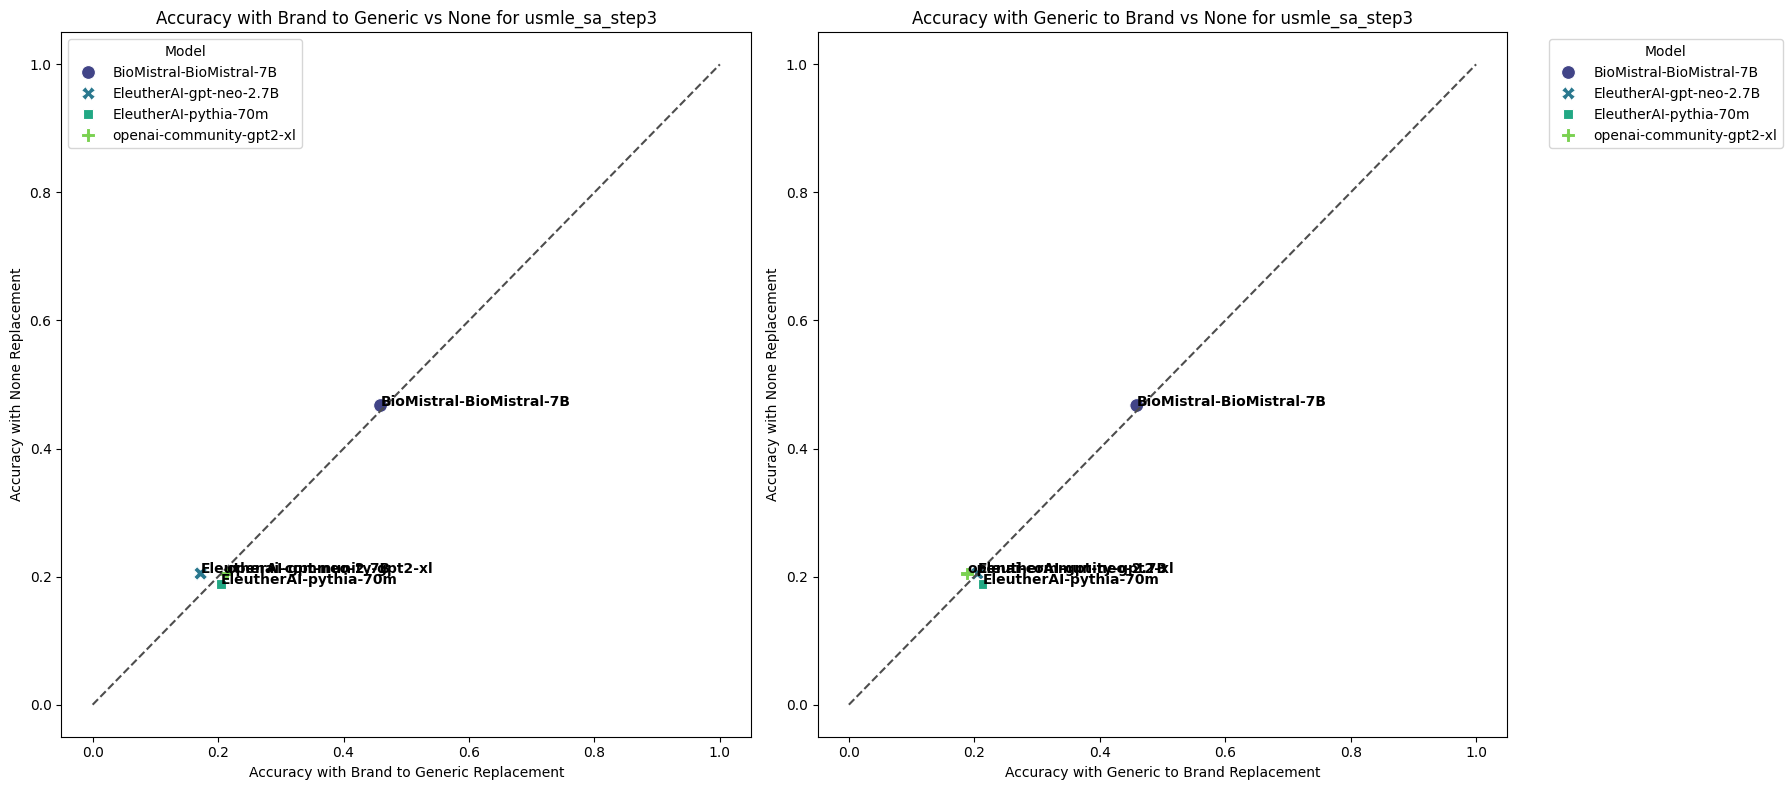

In [41]:
# Filter the results DataFrame to include only accuracy metrics for "none", "brand_to_generic", and "generic_to_brand"
filtered_results_df = results_df_filtered[
    results_df_filtered["Direction"].isin(
        ["none", "brand_to_generic", "generic_to_brand"]
    )
]

# Pivot the DataFrame to have directions as columns
pivot_results = filtered_results_df.pivot_table(
    index=["Dataset", "Model"], columns="Direction", values="Value"
).reset_index()

# Get the unique tasks
tasks = pivot_results["Dataset"].unique()

# Create scatter plots for each task
for task in tasks:
    task_data = pivot_results[pivot_results["Dataset"] == task]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    # Scatter plot for brand_to_generic
    sns.scatterplot(
        data=task_data,
        x="brand_to_generic",
        y="none",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[0],
    )
    for line in range(0, task_data.shape[0]):
        axes[0].text(
            task_data["brand_to_generic"].iloc[line],
            task_data["none"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[0].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[0].set_title(f"Accuracy with Brand to Generic vs None for {task}")
    axes[0].set_xlabel("Accuracy with Brand to Generic Replacement")
    axes[0].set_ylabel("Accuracy with None Replacement")

    # Scatter plot for generic_to_brand
    sns.scatterplot(
        data=task_data,
        x="generic_to_brand",
        y="none",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[1],
    )
    for line in range(0, task_data.shape[0]):
        axes[1].text(
            task_data["generic_to_brand"].iloc[line],
            task_data["none"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[1].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[1].set_title(f"Accuracy with Generic to Brand vs None for {task}")
    axes[1].set_xlabel("Accuracy with Generic to Brand Replacement")
    axes[1].set_ylabel("Accuracy with None Replacement")

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()